# Flatiron Phase 3 Project

## Aaron Galbraith

### Submitted: ———

# Business Understanding

A number of organizations install and manage water wells throughout the country of Tanzania. Some of these wells become unfunctional from time to time and need to be repaired or replaced.

The government of Tanzania funds over 9,000 of these wells, about 15%. The government would like to be able to predict which wells are going to remain functioning without having to systematically check each one.


# Data Understanding

## Import files

Here we'll import everything we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from itertools import combinations

from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from scipy import stats

from xgboost import XGBClassifier

SEED = 10

First we'll open the various docs and see how big they are.

In [2]:
df = pd.read_csv('../data/training_set_values.csv')
# show row and column counts
df.shape

(59400, 40)

In [3]:
# show first few records
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


"training_set_values" has 59,400 records.

In [4]:
df = pd.read_csv('../data/training_set_labels.csv')
# show row and column counts
df.shape

(59400, 2)

In [5]:
# show first few records
df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
# show value counts for the target variable
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

"training_set_labels" just tells you what the status of those 59,400 records is.

In [7]:
df = pd.read_csv('../data/test_set_values.csv')
# show row and column counts
df.shape

(14850, 40)

In [8]:
# show first few records
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


"test_set_values" is just like training_set_values, with fewer records (14,850).

In [9]:
df = pd.read_csv('../data/SubmissionFormat.csv')
# show row and column counts
df.shape

(14850, 2)

In [10]:
# show first few records
df.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


"SubmissionFormat" is like training_set_labels except the contestant/data scientist has to provide the labels.

## Summary of available files

There is a training set consisting of 59,400 records, a set of labels for those 59,400 records,  a test set consisting of 14,850 records, and a template for submitting labels for those 14,850 test records to an online contest.

Because we do not have labels for the 14,850 records in the test set, those are useless to us. We will have to carve out training and test sets from the 59,400 records with known labels.

## Create the desired data set

As we drop records from the data set, we'll need to make sure we drop the *same* records from the target labels, so it will be necessary to join those two dataframes together first.

In [11]:
# load the data from two files
dfX = pd.read_csv('../data/training_set_values.csv')
dfy = pd.read_csv('../data/training_set_labels.csv')
# concatenate the files and rename 'status group' column as 'target' for more universal model application
df = pd.concat([dfX, dfy['status_group']], axis = 1).rename(columns={'status_group': 'target'})
# show rows and columns
df.shape

(59400, 41)

We're only interested in whether the wells are functional or not, so we can encode the target label accordingly before proceeding with data preparation.

We'll adopt the labeling tradition where the baseline / status quo (functional well) is coded as 0 and the *problem* (non-functioning well) is coded as 1.

In [12]:
# label encode the target feature
df['target'] = df['target'].apply(lambda x: 0 if x == 'functional' else 1)

# Data preparation

## Duplicates

First we'll address duplicates.

In [13]:
# check for duplicates, excluding the ids
df[df.duplicated(subset=df.columns.difference(['id']))].shape

(36, 41)

There appear to be 36 duplicated records. We'll drop them.

In [14]:
# drop the duplicate records
df.drop(df[df.duplicated(subset=df.columns.difference(['id']))].index, inplace=True)
# show row and column counts
df.shape

(59364, 41)

## Trim data to Government-funded wells

As we'll only be working with records of wells funded by the government, we should drop all other records before going any further. Once we've done that, we can drop the funder feature.

We'll want to look carefully at the various ways this could have been labeled. We'll search for anything whose funder value contains 'gov'.

In [15]:
# convert this column to lowercase in order to make searching simpler
df['funder'] = df['funder'].str.lower()
# search for entries containing 'gov'
df[df['funder'].str.contains('gov', na=False) ].  funder.value_counts().head(15)

government of tanzania         9076
finida german tanzania govt      53
china government                 51
village government               27
cipro/government                 21
norad /government                20
finland government               16
isf/government                   16
finidagermantanzania govt        11
government/ community            11
dhv/gove                         10
belgian government               10
government/ world bank            9
government /tassaf                8
british colonial government       8
Name: funder, dtype: int64

There don't appear to be many records that should be included in the 'government of tanzania' label. Some, such as 'cipro/government', appear to be partnerships, and in any case there are relatively few of them.

Now we'll look for values containing 'tan'.

In [16]:
# search for entries containing 'tan'
df[df['funder'].str.contains('tan', na=False) ].  funder.value_counts().head(15)

government of tanzania            9076
tanza                               88
finida german tanzania govt         53
tanapa                              51
tanzakesho                          24
tanzania                            18
finidagermantanzania govt           11
hortanzia                            9
tanap                                5
free pentecoste church of tanz       4
tanesco                              4
cartas tanzania                      4
stantons                             3
koica and tanzania government        3
tanz egypt technical cooper          3
Name: funder, dtype: int64

It seems fair to assume the label 'tanzania' indicates that the country's government is the funder. We'll change these labels and move on with trimming the records and dropping this column.

In [17]:
# change any label of 'tanzania' to 'government of tanzania'
df['funder'] = df['funder'].apply(lambda x: 'government of tanzania' if x == 'tanzania' else x)
# drop all records of wells funded by any organization other than the government of Tanzania
df.drop(df[df['funder'] != 'government of tanzania'].index, inplace=True, axis=0)
# drop this feature, as its values are all now uniform
df.drop(columns='funder', inplace=True)
# show rows and columns
df.shape

(9094, 40)

## Missing values

Now we'll look at which columns have missing values.

In [18]:
# show columns with missing values and the number of values missing
df[df.columns[df.isna().any()]].isna().sum()

installer               4
subvillage             70
public_meeting        418
scheme_management     537
scheme_name          2720
permit                 41
dtype: int64

For any feature with missing values, our options are:

1. drop the feature
2. save the feature by imputing the missing values
3. save the feature by dropping the records with missing values

The features identified here with missing values are all categorical features, which means there is little hope for imputing their values. The only way we could hope to impute values for any of these features is if it made sense to assign the value of "other" to the missing values. Even then, this will only be worthwhile if doing so leaves us with sufficiently *few* unique values for that feature. The reason for this is that in a categorization project such as this one, it simply won't be useful to have a large number of unique values for any single feature.

If, say, 1-4 values comprised something like 70% of the records, then it *might* make sense to put all the rest — including the missing values — into an "other" value pile. But if the value counts are more or less evenly distributed, then there won't be much hope of imputing, and we'll have to decide whether to drop the feature or drop the records with missing values for that feature.

In [19]:
# show how many unique values each feature has, for the features that also have missing values
df[df.columns[df.isna().any()]].nunique()

installer             127
subvillage           3961
public_meeting          2
scheme_management      10
scheme_name           810
permit                  2
dtype: int64

Let's start with the worst offender, scheme name. It's missing almost a third of its values, and the values that it has are distributed across 808 unique values. Let's look at counts of its top unique values.

In [20]:
df.scheme_name.value_counts().head(10)

Machumba estate pipe line      178
Government                     168
Borehole                       101
Nasula gravity water supply     93
Kidia kilemapunda               86
None                            80
Olkokola pipe line              79
Una mkolowoni                   79
Komaka mandaka                  73
Kaisho/Isingiro w               70
Name: scheme_name, dtype: int64

Since we're focusing just on government-funded wells, there does seem to be something potentially interesting aobut the wells that have Government for their scheme name (which the documentation explains means the government runs those wells). However, there are only 168 of these wells, less than 2% of our current data set. We'll just drop the feature.

In [21]:
df.drop(columns='scheme_name', inplace=True)
# show row and column counts
df.shape

(9094, 39)

Let's do the same analysis for the subvillage feature since it also has a great number of unique values.

In [22]:
df.subvillage.value_counts().head(10)

Majengo          99
Madukani         91
Marurani Kati    59
Marurani Juu     54
Shuleni          46
Kati             39
Mtakuja          39
Muungano         34
Bwawani          32
Kibaoni          31
Name: subvillage, dtype: int64

This also seems too evenly distributed across too many values to be helpful in modeling. We'll drop it.

In [23]:
df.drop(columns='subvillage', inplace=True)
# show row and column counts
df.shape

(9094, 38)

Let's look at scheme management.

In [24]:
df.scheme_management.value_counts().head(10)

VWC                 6400
Water authority      786
WUA                  385
WUG                  293
Company              277
Water Board          212
Parastatal           115
Other                 73
Private operator      15
Trust                  1
Name: scheme_management, dtype: int64

With such a great number concentrated in a few unique values, this looks more promising. Let's look at this as a pie chart, making sure the "missing values" get included as such by relabeling them as "MISSING".

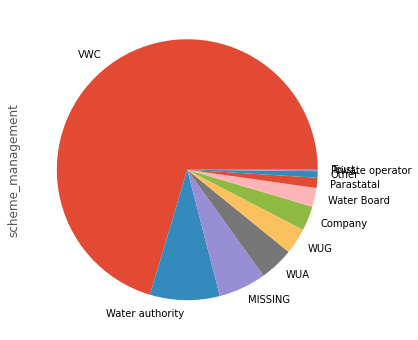

In [25]:
# relabel missing values
df['scheme_management'].fillna('MISSING', inplace=True)
# plot pie chart of the unique values for scheme_management with highest value counts
df.scheme_management.value_counts().plot.pie(subplots=True, figsize = (11,6), legend=False);

Here we see an opportunity to group some values together. Let's replace any value with lower counts than "Other" as "Other", and group the missing values as "Other" as well.

In [26]:
# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.scheme_management.value_counts().index:
    if len(df[df.scheme_management == val]) < len(df[df.scheme_management == 'Other']):
        other_vals.append(val)

# reset the values
df['scheme_management'] = df['scheme_management'].apply(lambda x: 'Other' if x in other_vals else x)
# fill any missing values with 'Other'
df['scheme_management'] = df['scheme_management'].apply(lambda x: 'Other' if x == 'MISSING' else x)

Let's look at the installer feature.

In [27]:
df.installer.value_counts().head(15)

DWE                        4258
Government                 1600
RWE                         648
District council            295
Commu                       261
Gover                       241
Centr                       162
Community                   159
District Council            150
Central govt                138
GOVER                       117
Central Government          110
Gove                         91
Central government           90
Region water Department      77
Name: installer, dtype: int64

This strongly indicates that some of the labels should be consolidated. We'll make those consolidations before we look at the value counts again.

In [28]:
df['installer'] = df['installer'].apply(
    lambda x: 'Government' if x in ['Gover', 'Centr', 'Central govt', 'Central govt', 'GOVER', 'Central Government',
                                    'Gove', 'Central government', 'Tanzania Government', 'GOVERNMENT', 'GOVERN',
                                   'Ce', 'Go', 'CENTRAL GOVERNMENT', 'central government', 'Cental Government',
                                   'Cebtral Government', 'Tanzanian Government', 'GOVERM', 'GOVERNME',
                                   'Centra govt', 'Cetral government /RC'] else x)
df['installer'] = df['installer'].apply(
    lambda x: 'District Council' if x in ['District council', 'Distri', 'DISTRICT COUNCIL',
                                          'Mbozi District Council', 'Council', 'District  Council'] else x)
df['installer'] = df['installer'].apply(
    lambda x: 'Community' if x in ['Commu', 'RWE /Community', 'RWE/Community', 'RWE/ Community', 'COMMU',
                                   'RWE Community', 'Communit', 'District Community j'] else x)
df['installer'] = df['installer'].apply(
    lambda x: 'DWE' if x in ['Dwe', 'DW'] else x)
df.installer.value_counts().head(15)

DWE                           4262
Government                    2726
RWE                            648
District Council               489
Community                      444
Region water Department         77
District Water Department       72
Sengerema Water Department      65
DDCA                            49
MUWASA                          28
WEDECO                          27
TCRS                            19
RW                              12
Handeni Trunk Main(             12
Local                           11
Name: installer, dtype: int64

Once again, this looks promising. Let's give the missing values a label and visualize with a pie chart again.

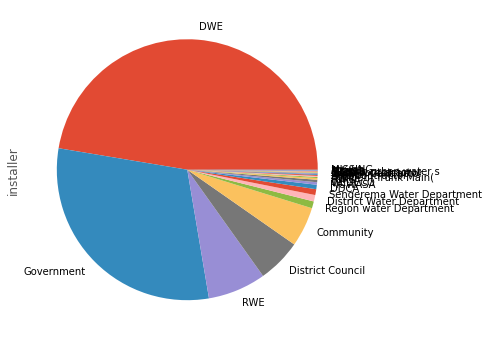

In [29]:
# relabel missing values
df['installer'].fillna('MISSING', inplace=True)
# plot pie chart of 25 unique values for installer with highest value counts
df.installer.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

Here again we can group anything with a value count smaller than that of Community as "other".

In [30]:
# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.installer.value_counts().index:
    if len(df[df.installer == val]) < len(df[df.installer == 'Community']):
        other_vals.append(val)

# reset the values
df['installer'] = df['installer'].apply(lambda x: 'Other' if x in other_vals else x)
# fill any missing values with 'Other'
df['scheme_management'] = df['scheme_management'].apply(lambda x: 'Other' if x == 'MISSING' else x)

The remaining features with missing values — public_meeting and permit — have only two unique values each. It could get a little trickier to impute anything here. Let's look at those values, starting with public_meeting.

In [31]:
df.public_meeting.value_counts()

True     7841
False     835
Name: public_meeting, dtype: int64

In [32]:
df.permit.value_counts()

True     6785
False    2268
Name: permit, dtype: int64

It's difficult to justify imputing anything here, even an "other" category, so for each of these features we'll have to either drop the feature or drop the records. The missing values for public_meeting are nearly 5% of the data, and we don't even know how helpful this feature will be yet, so it's safe to drop it.

In [33]:
df.drop(columns='public_meeting', inplace=True)
# show row and column counts
df.shape

(9094, 37)

There are fewer missing values for the permit feature, however, only about half of a percent, so we can instead drop those records. (And if we later discover that the permit feature doesn't help in our modeling, we can perhaps add those records back and drop the permit feature.)

In [34]:
df.drop(df[df.permit.isna()].index, inplace=True)
# show row and column counts
df.shape

(9053, 37)

## Administrative features
The id, date_recorded, and recorded_by features won't help with any of our analysis. We can safely drop them.

In [35]:
df.drop(columns=['id', 'date_recorded', 'recorded_by'], inplace=True)
# show row and column counts
df.shape

(9053, 34)

## Numerical features with potentially false zeros

We've tackled all the missing values already, but sometimes values of zero are entered when the value is actually missing.

Let's explore the numerical features and find how many zero values each has and what percentage of its values are zero.

In [36]:
for col in df.select_dtypes(include=['number']).columns:
    count = df[col][abs(df[col]) == 0].count()
    pct = round(100*count/(len(df)),2)
    print(col, (19-len(col))*' ', count, (5-len(str(count)))*' ', pct, '%')

amount_tsh           6989   77.2 %
gps_height           2576   28.45 %
longitude            234    2.58 %
latitude             0      0.0 %
num_private          8912   98.44 %
region_code          0      0.0 %
district_code        0      0.0 %
population           2818   31.13 %
construction_year    2686   29.67 %
target               3709   40.97 %


### Region code and district code

First, it would seem that region_code and district_code are actually *categorical* variables, not numerical. Let's look at a sample of those values and see how many unique values there are for each.

In [37]:
# show some values for region and district codes
df[['region_code', 'district_code']].head(10)

,region_code,district_code
25,3,4
28,3,1
32,3,4
39,16,1
41,11,3
44,2,2
53,19,6
59,18,2
61,4,1
67,18,1


In [38]:
# show how many unique values there are for each feature
df[['region_code', 'district_code']].nunique()

region_code      23
district_code    15
dtype: int64

There's nothing to suggest that region and district codes should be regarded as numerical. We'll convert them to string objects and later apply one-hot encoding to these features.

In [39]:
# convert region_code to string object
df['region_code'] = df['region_code'].astype('object')
# convert district_code to string object
df['district_code'] = df['district_code'].astype('object')

### Num_private

Next, nearly 99% of the records have a zero value for the num_private column, and further, the documentation gives no explanation at all of what num_private is. We'll drop this feature.

In [40]:
# drop num_private
df.drop(columns='num_private', inplace=True)
# show row and column counts
df.shape

(9053, 33)

### Construction Year

Let's sample the construction_year values.

In [41]:
# show some values for construction year
df.construction_year.value_counts().head()

0       2686
1972     507
1974     415
2010     317
1976     277
Name: construction_year, dtype: int64

As expected, these zero values make no sense. There's no way to impute the actual values for this feature, and roughly a third of the records have missing values in this column. We'll have to drop that feature.

That's unfortunate, because this feature could reasonably have been helpful.

In [42]:
# drop construction_year
df.drop(columns='construction_year', inplace=True)
# show row and column counts
df.shape

(9053, 32)

### Longitude and latitude

Maps show that locations within Tanzania's boundaries should have longitude values roughly between 29 and 40, so the zero values here are certainly false.

And the latitude values should be roughly between -1 and -11.

Let's look at a histogram of the *non*-zero longitudes and *all* the latitudes to confirm what we have.

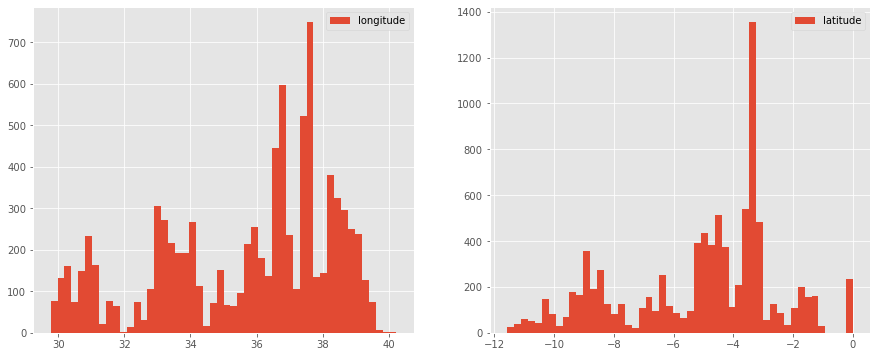

In [43]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15,6))
# plot histogram of nonzero longitudes
df[df.longitude != 0].longitude.hist(bins=50, ax=ax1, legend=True)
# plot histogram of all latitudes
df.latitude.hist(bins=50, ax=ax2, legend=True);

The nonzero longitudes check out fine, but there seem to be some *near*-zero latitudes. Let's take a closer look at these values. Specifically, let's look at the *longitude* values for these near-zero *latitudes*.

In [44]:
# show longitude values for near-zero latitude records
df[df.latitude > -.2].longitude.describe()

count    234.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: longitude, dtype: float64

Just as expected, these near-zero latitude values are for the exact same (234) records that have zero longitude values.

The thing is, we will ultimately drop these two features before modeling anyway, because lat/long are not true numerical features, i.e. 20° longitude is not *twice as much* of anything as 10° is. These features were only ever going to help us plot and understand some of the other features, so the only issue is that we'll be missing some records when we do that.

### GPS height (altitude)

Next let's investigate gps_height. Since Tanzania has a coastline along the Indian Ocean, it's plausible that some locations are in fact at zero elevation. Let's use the (nonzero) lat/long values to explore this.

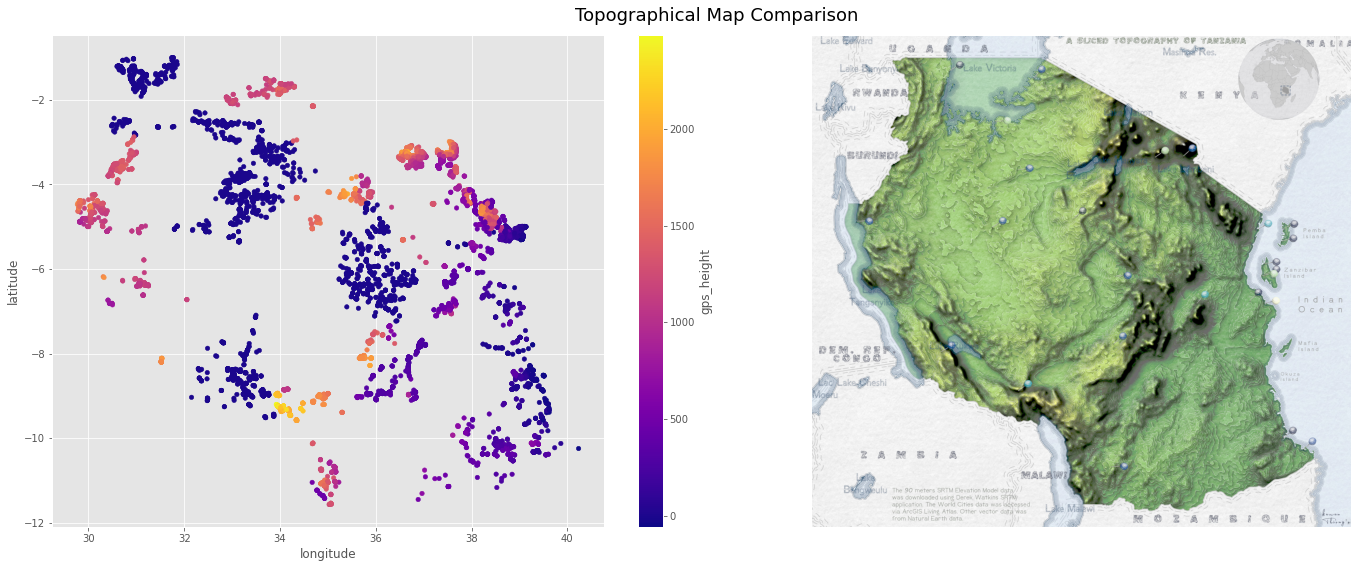

In [45]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# plot long/lat for nonzero longs with color gradient for elevation
df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='gps_height', cmap='plasma', ax=ax1)
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Topographical Map Comparison', size=18)
fig.tight_layout();

The data-generated plot on the left indicates that there are lower elevations near the coastline, but there are also many lower elevations in inland areas. A cursory comparison against the actual topographical map on the right suggests those inland areas probably can't be that low, but let's look at a scatterplot of which records are *exactly* zero.

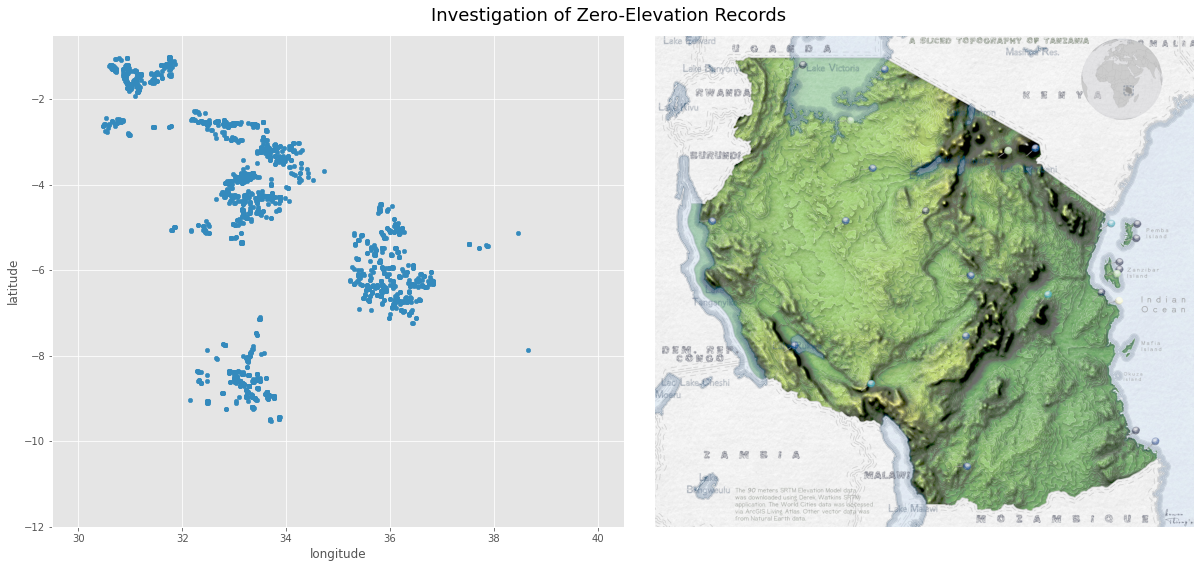

In [46]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(17,8))
# plot long/lat of *only* zero elevation records
df[(df.longitude > 0) & (df['gps_height'] == 0)].plot.scatter(
    x='longitude', y='latitude', ax=ax1)
# set the axis ranges to match the ones in the previous plot
ax1.set_xlim([29.5, 40.5])
ax1.set_ylim([-12, -0.5])
# upload an image
im = plt.imread("../images/topo_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Investigation of Zero-Elevation Records', size=18)
fig.tight_layout();

These locations can't possibly (all) have an elevation of (exactly) zero. It may be possible to impute those elevation values, but we'll have to consider that at a later point.

### Population

The next feature with zero values to explore is population. Let's use another scatterplot map to get a better understanding of this feature.

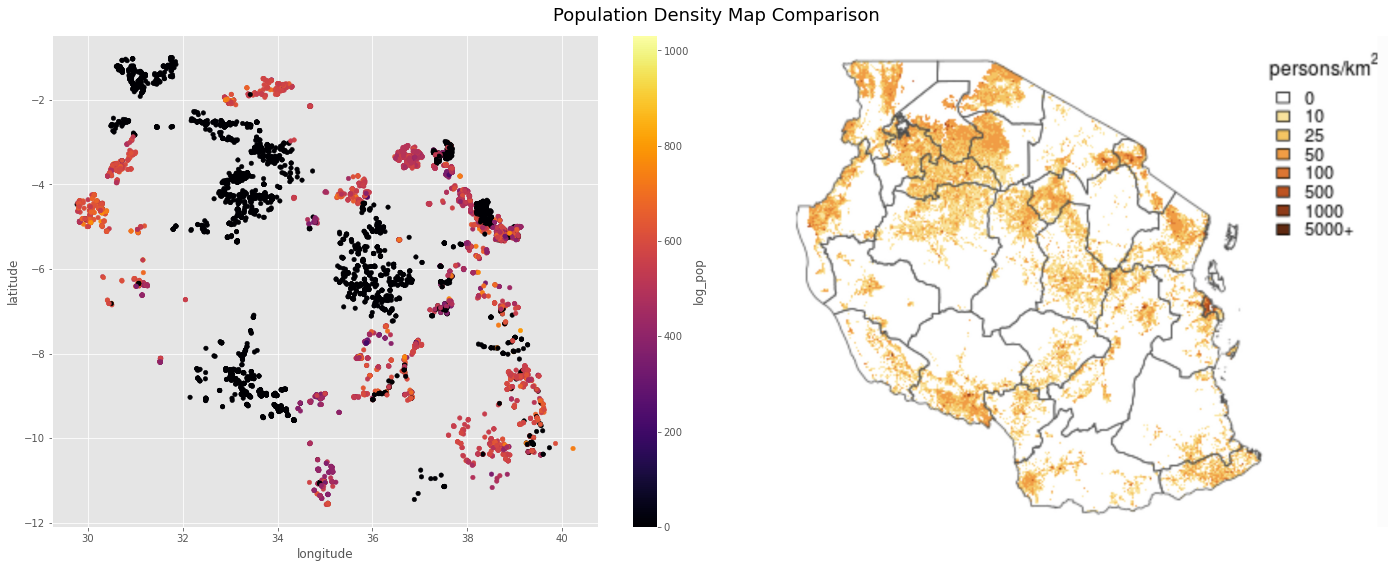

In [47]:
# set figure with two axes over two columns
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,8))
# create a temporary feature that calculates the logarithm of the population
df['log_pop'] = df.population.apply(lambda x: 0 if x <= 1 else int(np.log(x)*100))
# plot long/lat for nonzero longs with color gradient for population

df[df.longitude > 0].plot.scatter(x='longitude', y='latitude', c='log_pop', cmap='inferno', ax=ax1);
# drop the log_pop column that was created
df.drop(columns='log_pop', inplace=True)
# upload an image
im = plt.imread("../images/pop_map.jpeg")
# display the image
im = ax2.imshow(im)
# hide X and Y axes label marks
ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)
# hide X and Y axes tick marks
ax2.set_xticks([])
ax2.set_yticks([])
# title
fig.suptitle('Population Density Map Comparison', size=18)
fig.tight_layout();

We've calculated logarithm values of the population records in order to better distinguish the values and then plotted them on the left. On the right, for comparison, is a presumably accurate population density map of Tanzania from the UC Davis website (https://gfc.ucdavis.edu/profiles/rst/tza.html).

For one thing, we can see that there are water wells pretty much everywhere that there are people, which is good! However, our data suggests that there *aren't* any people at the locations in black. That's inconsistent with the population density map on the right. As these zero values again constitute roughly a third of the records, it looks like we'll have to drop the population feature, too.

It's not likely that knowing the population in a given area would have factored into explaining whether their wells were functioning, so dropping this feature probably isn't such a great loss.

In [48]:
# drop population
df.drop(columns='population', inplace=True)
# show row and column counts
df.shape

(9053, 31)

### Total static head

The last remaining zero value is for amount_tsh or "total static head". The documentation doesn't do much to clarify this term, but some light googling (e.g. https://www.rfmacdonald.com/documents/Goulds-Centrifugal%20Pump%20Fundamentals.pdf) reveals that this refers to the vertical distance between the source water level and the level at which the water is accessed. As far as we know, it's quite plausible indeed for this value to be zero, so we'll leave it.

That point may deserve more attention: We are assuming that the zero values for total static head are *valid*, and they account for over 3/4 of the records. It's possible we'll want to revisit this later.

## Large number of unique values

Let's look at other categorical features with too many unique values to factor into our analysis.

In [49]:
df.select_dtypes(include='object').loc[
    :, df.select_dtypes(include='object').apply(lambda x: x.nunique()) > 10].nunique()

wpt_name                 6442
region                     20
region_code                23
district_code              15
lga                        80
ward                      883
extraction_type            17
extraction_type_group      13
management                 11
dtype: int64

### Waterpoint name, Ward, and LGA

We'll investigate wpt_name, ward, and lga using the pie chart method we used earlier.

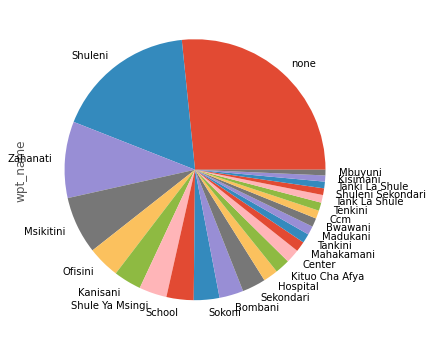

In [50]:
# plot pie chart of 25 unique values for wpt_name with highest value counts
df.wpt_name.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

We see that the largest number of these values are actually missing, and the rest are rather evenly distributed, so we can safely drop them.

In [51]:
df.drop(columns='wpt_name', inplace=True)
# show row and column counts
df.shape

(9053, 30)

Here's the pie chart for the ward feature.

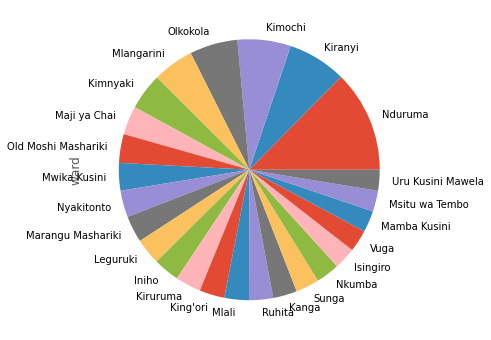

In [52]:
# plot pie chart of 25 unique values for ward with highest value counts
df.ward.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

There's no apparent way to group these into anything useable. We'll drop it.

In [53]:
df.drop(columns='ward', inplace=True)
# show row and column counts
df.shape

(9053, 29)

Here's the pie chart for the lga feature.

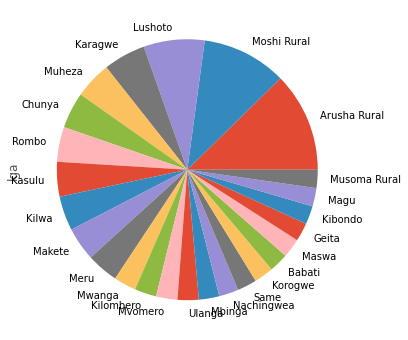

In [54]:
# plot pie chart of 25 unique values for lga with highest value counts
df.lga.value_counts().head(25).plot.pie(subplots=True, figsize = (11,6), legend=False);

This will have to go as well.

In [55]:
df.drop(columns='lga', inplace=True)
# show row and column counts
df.shape

(9053, 28)

The three features we just dropped were all geographical identifiers. It's not clear whether that kind of feature would be useful in our modeling or not.

## Geographical identifiers

These features serve as geographical identifiers: basin, region, region_code, and district_code. There is likely to be some redundancy among these features, and we should generally try to understand them better.

We'll start by plotting all of the basins.

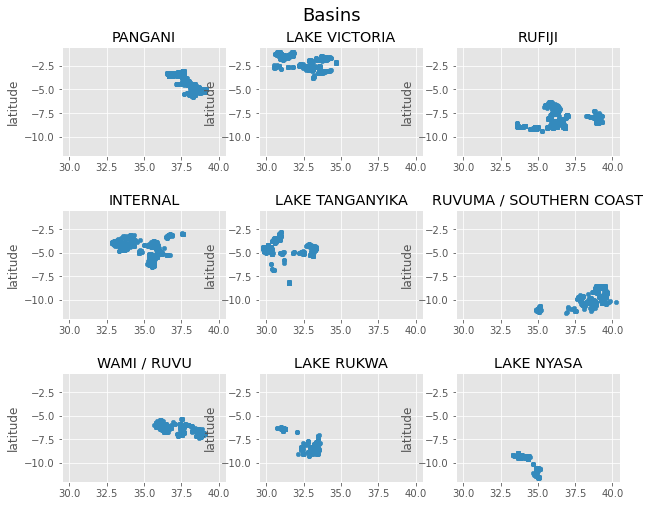

In [56]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Basins", fontsize=18, y=0.95)

# loop through basins and axes
for basin, ax in zip(df.basin.value_counts().index, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df[df['basin'] == basin].plot.scatter(x='longitude', y='latitude', ax=ax)

    # chart formatting
    ax.set_title(basin.upper())
    ax.set_xlabel("")
    ax.set_xlim([29.5, 40.5])
    ax.set_ylim([-12, -0.5])

plt.show();

They appear to be contiguous and generally separate regions, which looks good.

Let's do the same for district codes.

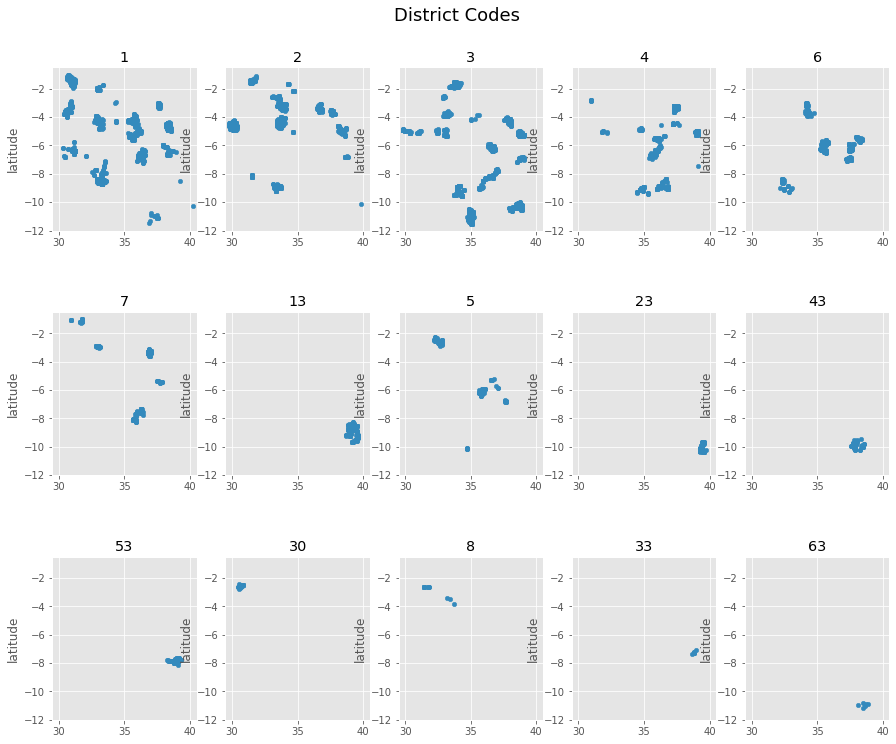

In [57]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("District Codes", fontsize=18, y=0.95)

# loop through basins and axes
for code, ax in zip(df.district_code.value_counts().index, axs.ravel()):
    # filter df for district code and plot on specified axes
    df[df['district_code'] == code].plot.scatter(x='longitude', y='latitude', ax=ax)

    # chart formatting
    ax.set_title(str(code).upper())
    ax.set_xlabel("")
    ax.set_xlim([29.5, 40.5])
    ax.set_ylim([-12, -0.5])

plt.show();

The first several "districts" seem to overlap a great deal. Since we can't make proper sense of this feature, we'll drop it.

In [58]:
df.drop(columns='district_code', inplace=True)
# show row and column counts
df.shape

(9053, 27)

Next, we'll look at the region feature.

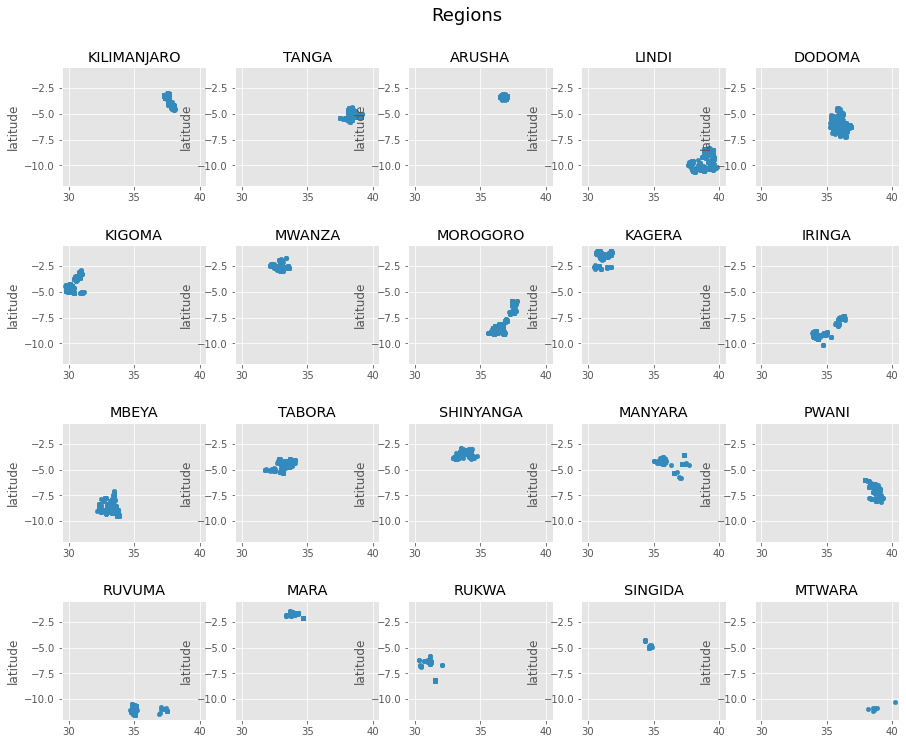

In [59]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Regions", fontsize=18, y=0.95)

# loop through regions and axes
for region, ax in zip(df.region.value_counts().index, axs.ravel()):
    # filter df for region and plot on specified axes
    df[df['region'] == region].plot.scatter(x='longitude', y='latitude', ax=ax)

    # chart formatting
    ax.set_title(region.upper())
    ax.set_xlabel("")
    ax.set_xlim([29.5, 40.5])
    ax.set_ylim([-12, -0.5])

plt.show();

These also appear to be contiguous and separate.

To recap our geographical identifiers, we already dropped, "ward", "subvillage", "lga", and "wpt_name", and we have now dropped "district code" (and will soon drop region code), leaving just basin and region.

It would seem the "basin" is a natural distinction, whereas "region" is one imposed by governing bodies. It will be interesting to note which of these ultimately proves more meaningful.

## Possibly redundant features

Several features seem to be related, such as waterpoint_type and waterpoint_type_group. In such cases, we would generally prefer to keep the one with fewer unique values and drop the other(s). Let's look at value counts for groups of features that seem to be related.

To help in this, we'll create a function that compares how different values correlate with the success of a well. This will be better explained in the first example that follows.

In [60]:
def compare_vals(feature, vals):
    for val in vals:
        num = len(df[(df[feature] == val) & (df['target'] == 0)])
        denom = len(df[df[feature] == val])
        print(val, "%.0f%%" % (100 * num / denom))

### region / code

In [61]:
df[['region_code', 'region']].value_counts()

region_code  region     
3            Kilimanjaro    1251
4            Tanga          1072
2            Arusha         1017
1            Dodoma          566
16           Kigoma          533
19           Mwanza          513
5            Morogoro        510
18           Kagera          474
11           Iringa          465
12           Mbeya           457
80           Lindi           418
14           Tabora          332
17           Shinyanga       309
21           Manyara         265
10           Ruvuma          175
20           Mara            174
8            Lindi           151
15           Rukwa           138
6            Pwani           130
60           Pwani            59
13           Singida          34
90           Mtwara            7
18           Lindi             2
99           Mtwara            1
dtype: int64

There are only a *very* few repetitions of regions with different code numbers here. We'll keep "region", since there are fewer of them, and we'll drop "region code".

In [62]:
df.drop(columns='region_code', inplace=True)
# show row and column counts
df.shape

(9053, 26)


### Extraction type / group / class

In [63]:
df[['extraction_type', 'extraction_type_group']].value_counts()

extraction_type            extraction_type_group
gravity                    gravity                  5550
other                      other                     849
mono                       mono                      635
submersible                submersible               563
nira/tanira                nira/tanira               474
ksb                        submersible               301
swn 80                     swn 80                    266
india mark ii              india mark ii             188
afridev                    afridev                   124
other - swn 81             other handpump             28
other - rope pump          rope pump                  25
climax                     other motorpump            21
windmill                   wind-powered               14
india mark iii             india mark iii              5
cemo                       other motorpump             5
other - play pump          other handpump              4
other - mkulima/shinyanga  other handpu

The only significant consolidation done here is the types "submersible" and "ksb" get consolidated into the group "submersible". Let's see how distinct these types are.

In [64]:
compare_vals('extraction_type', ['submersible', 'ksb'])

submersible 48%
ksb 6%


This means that 48% of waterpoints of extraction type "submersible" are functional, and 6% of extraction type "ksb" are functional. That seems like an important difference, it may make the most sense to perserve this distinction but then just consolidate everything with a group size smaller than "afridev" into the "other" group.

In [65]:
# reassign values in the "submersible" group
df['extraction_type_group'] = df.apply(
    lambda x: 'ksb' if x.extraction_type == 'ksb' else x.extraction_type_group, axis=1)

# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.extraction_type_group.value_counts().index:
    if len(df[df.extraction_type_group == val]) < len(df[df.extraction_type_group == 'afridev']):
        other_vals.append(val)

# reset the values
df['extraction_type_group'] = df['extraction_type_group'].apply(lambda x: 'other' if x in other_vals else x)

Having edited the extraction group, we can drop the extraction type feature.

In [66]:
df.drop(columns='extraction_type', inplace=True)
# show row and column counts
df.shape

(9053, 25)

Now we need to further consider which feature to keep between extraction type "group" and "class". We'll look at the value counts.

In [67]:
df[['extraction_type_group', 'extraction_type_class']].value_counts()

extraction_type_group  extraction_type_class
gravity                gravity                  5550
other                  other                     849
mono                   motorpump                 635
submersible            submersible               563
nira/tanira            handpump                  474
ksb                    submersible               301
swn 80                 handpump                  266
india mark ii          handpump                  188
afridev                handpump                  124
other                  handpump                   38
                       motorpump                  26
                       rope pump                  25
                       wind-powered               14
dtype: int64

We may explore this more in depth later or change our minds during modeling, but for now we'll keep the feature with fewer unique values and drop the other.

In [68]:
df.drop(columns='extraction_type_group', inplace=True)
# show row and column counts
df.shape

(9053, 24)

### Management / group

In [69]:
df[['management', 'management_group']].value_counts()

management        management_group
vwc               user-group          7134
wua               user-group           379
water board       user-group           360
wug               user-group           320
company           commercial           258
water authority   commercial           180
other             other                161
parastatal        parastatal           129
private operator  commercial            67
unknown           unknown               63
trust             commercial             2
dtype: int64

Based on the value counts, it seems best to keep the different user-groups but consolidate the rest into "commercial" and "other".

In [70]:
# reassign values
df['management'] = df.apply(
    lambda x: 'commercial' if x.management_group == 'commercial' else x.management, axis=1)

# create an empty list to be populated by values whose value counts are higher than a certain threshold
other_vals = []

# populate the list
for val in df.management.value_counts().index:
    if len(df[df.management == val]) < len(df[df.management == 'wug']):
        other_vals.append(val)

# reset the values
df['management'] = df['management'].apply(lambda x: 'other' if x in other_vals else x)

Then we can drop the other feature.

In [71]:
df.drop(columns='management_group', inplace=True)
# show row and column counts
df.shape

(9053, 23)

### payment / type

In [72]:
df[['payment', 'payment_type']].value_counts()

payment                payment_type
never pay              never pay       4700
unknown                unknown         1217
pay monthly            monthly         1207
pay per bucket         per bucket      1158
pay when scheme fails  on failure       346
pay annually           annually         295
other                  other            130
dtype: int64

These are in a precise one-to-one correspondence, so one can be dropped without question.

In [73]:
df.drop(columns='payment_type', inplace=True)
# show row and column counts
df.shape

(9053, 22)

### Water quality / group

In [74]:
df[['water_quality', 'quality_group']].value_counts()

water_quality       quality_group
soft                good             8025
salty               salty             617
unknown             unknown           283
fluoride            fluoride           44
milky               milky              36
coloured            colored            26
salty abandoned     salty              18
fluoride abandoned  fluoride            4
dtype: int64

The values here seem too small to matter, so we'll keep the feature that's more consolidated and drop "water quality".

In [75]:
df.drop(columns='water_quality', inplace=True)
# show row and column counts
df.shape

(9053, 21)

### Water quantity / group

In [76]:
df[['quantity', 'quantity_group']].value_counts()

quantity      quantity_group
enough        enough            4681
insufficient  insufficient      3022
dry           dry                953
seasonal      seasonal           306
unknown       unknown             91
dtype: int64

This is another one-to-one match, so we can just drop one of them.

In [77]:
df.drop(columns='quantity_group', inplace=True)
# show row and column counts
df.shape

(9053, 20)

### source / type / class

In [78]:
df[['source', 'source_type']].value_counts()

source                source_type         
spring                spring                  4010
machine dbh           borehole                1446
river                 river/lake              1384
shallow well          shallow well            1323
lake                  river/lake               321
rainwater harvesting  rainwater harvesting     247
dam                   dam                      243
hand dtw              borehole                  50
other                 other                     18
unknown               other                     11
dtype: int64

The only distinctions between source and source_type are that source recognizes two values for each of borehole, river/lake, and other. In every case, at least one of the value counts is small enough that there doesn't seem to be any harm in consolidating, so we'll keep "source type" and drop "source".

In [79]:
df.drop(columns='source', inplace=True)
# show row and column counts
df.shape

(9053, 19)

Let's consider the distinctions between source type and source class

In [80]:
df[['source_type', 'source_class']].value_counts()

source_type           source_class
spring                groundwater     4010
river/lake            surface         1705
borehole              groundwater     1496
shallow well          groundwater     1323
rainwater harvesting  surface          247
dam                   surface          243
other                 unknown           29
dtype: int64

We'll use our function to make some comparisons.

In [81]:
compare_vals('source_type', ['spring', 'borehole', 'shallow well'])

spring 50%
borehole 32%
shallow well 36%


In [82]:
compare_vals('source_type', ['river/lake', 'rainwater harvesting', 'dam'])

river/lake 33%
rainwater harvesting 59%
dam 18%


In [83]:
compare_vals('source_class', ['groundwater', 'surface'])

groundwater 43%
surface 34%


These all seem like interesting enough differences for the numbers of values involved. It's difficult to tell which one might be of more use to us.

At this point, we'll choose to keep the feature with fewer unique values and drop the other, but we could possibly revisit this later depending on how modeling goes.

In [84]:
df.drop(columns='source_type', inplace=True)
# show row and column counts
df.shape

(9053, 18)

### Waterpoint type / group

In [85]:
df[['waterpoint_type', 'waterpoint_type_group']].value_counts()

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       5257
communal standpipe multiple  communal standpipe       1399
hand pump                    hand pump                1152
other                        other                    1138
improved spring              improved spring            76
cattle trough                cattle trough              30
dam                          dam                         1
dtype: int64

The only difference here is that waterpoint_type distinguishes between two types of "communal standpipe". Let's see whether that makes any difference. The function created earlier will tell us whether this distinction matters and should be kept.

In [86]:
compare_vals('waterpoint_type', ['communal standpipe', 'communal standpipe multiple'])

communal standpipe 49%
communal standpipe multiple 24%


This means that 49% of waterpoints of type "communal standpipe" are functional, and 24% of the type "communal standpipe multiple" are functional. That seems like an important difference, so we'll keep the feature that makes that distinction and drop the other.

In [87]:
df.drop(columns='waterpoint_type_group', inplace=True)
# show row and column counts
df.shape

(9053, 17)

This should conclude the data preparation.

Since latitude and longitude won't be used in modeling, we can drop them now.

In [88]:
df.drop(columns=['longitude', 'latitude'], inplace=True)
# show row and column counts
df.shape

(9053, 15)

## Final data preparation steps

### One-hot encoding

It is a necessary step to one-hot encode all of the categorical features.

In [89]:
# one-hot encode the data
one_hot_df = pd.get_dummies(df)
# show row and column counts
one_hot_df.shape

(9053, 89)

### Creating train and test sets

In [90]:
# split the data into target and predictors
y = one_hot_df['target']
X = one_hot_df.drop(columns='target')
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

## Summary of prepared data

We now have just 2 numerical features, 12 categorical features, and 1 target variable for 9,035 records. One-hot encoding has expanded the 14 categorical features into 85 columns.

# Modeling

As discussed in our business understanding, we are particularly interested in the recall statistic for non-functional wells. To be clear, this recall statistic will show the number of true positives (correctly identified non-functional wells) divided by the number of non-functional wells. The reason for this interest is, again, is to minimize the error of identifying a well as functional when it is not, thus depriving its users of available water.

We'll create a handy function to use that will show both this recall statistic and the overall accuracy. The overall accuracy statistic will show the number of correctly identified wells (true positives and true negatives) out of the entire sample of wells in the test group.

In [91]:
# function that prints the recall and accuracy statistics as described above
def summary(y_test, y_pred):
    # calculate true positives
    true_pos = confusion_matrix(y_test, y_pred)[0][0]
    # calculate all actual positives
    all_pos = confusion_matrix(y_test, y_pred)[0].sum()
    # return recall

#     print('recall:   ', round(true_pos/all_pos,3))

    # calculate true negatives
    true_neg = confusion_matrix(y_test, y_pred)[1][1]
    # calculate all values
    all_all = confusion_matrix(y_test, y_pred).sum()
    # return accuracy
#     print('accuracy: ', round(((true_pos + true_neg)/all_all),3))
    
    return round(true_pos/all_pos,3), round(((true_pos + true_neg)/all_all),3)


It will be useful to first summarize the actual test data. We'll calculate the percentage of the test data that were actually positive (non-functional wells).

In [92]:
round(y_test.value_counts()[1] / y_test.value_counts().sum(),3)

0.598

This means that, if we simply declared every well to be non-functional, we would achieve this level of accuracy (and this level of recall).

## Logistic Regression (from 24.06)

This model uses basic logistic regresssion.

In [93]:
# instantiate a LogisticRegression
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=SEED)
# fit to the training data
logreg.fit(X_train, y_train)
# make predictions for test data
y_pred = logreg.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.695
accuracy:  0.742


We'll consider this our basline model.

## Decision Trees (from 26.06)

Here we'll use a decision tree classifier and set the max depth to 5.

In [94]:
# instantiate a DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=SEED)
# fit to the training data
dt_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = dt_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.737
accuracy:  0.735


This model has improved our recall by about 4% and worsened the accuracy by less than a rounding error. We'll consider this an overall improvement.

We can make the decision tree model better by hypertuning the max depth.

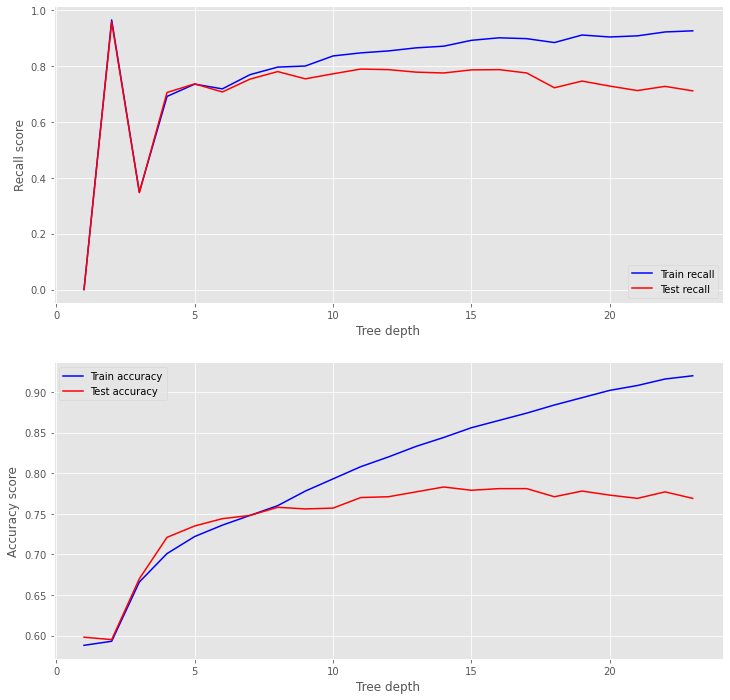

In [95]:
# identify the optimal tree depth for given data
max_depths = list(range(1, 24))
# create empty list for train results
train_recall_results, train_accuracy_results = [], []
# create empty list for test results
test_recall_results, test_accuracy_results = [], []
# iterate over max depths
for max_depth in max_depths:
    # instantiate a DecisionTreeClassifier
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
    # fit to the training data
    dt_clf.fit(X_train, y_train)
    # find what the model predicts for the training data
    y_train_pred = dt_clf.predict(X_train)
    # calculate relevant statistics for training data
    train_recall, train_accuracy = summary(y_train, y_train_pred)
    # add data to list of train results
    train_recall_results.append(train_recall)
    train_accuracy_results.append(train_accuracy)
    # find what the model predicts for the test data
    y_test_pred = dt_clf.predict(X_test)
    # calculate relevant statistics for test data
    test_recall, test_accuracy = summary(y_test, y_test_pred)
    # add data to list of test results
    test_recall_results.append(test_recall)
    test_accuracy_results.append(test_accuracy)
    
# set up the plots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12))

# specify the recall plot
ax1.plot(max_depths, train_recall_results, 'b', label='Train recall')
ax1.plot(max_depths, test_recall_results, 'r', label='Test recall')
ax1.set(xlabel='Tree depth', ylabel='Recall score')
ax1.legend()

# specify the accuracy plot
ax2.plot(max_depths, train_accuracy_results, 'b', label='Train accuracy')
ax2.plot(max_depths, test_accuracy_results, 'r', label='Test accuracy')
ax2.set(xlabel='Tree depth', ylabel='Accuracy score')
ax2.legend()

plt.show()

These plots, for recall and for accuracy, both indicate that a max tree depth less than 8 *underfits* the data, and a max tree depth greater than 8 *overfits* the data. We can be confident that a max tree depth of 8 fits the data as well as this model can possibly do.

Let's run it again with a max depth of 8.

In [147]:
# instantiate a DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=SEED)
# fit to the training data
dt_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = dt_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.781
accuracy:  0.758


Now the recall and accuracy are both improved!

Let's use "feature importances" to observe which features mattered most to this model.

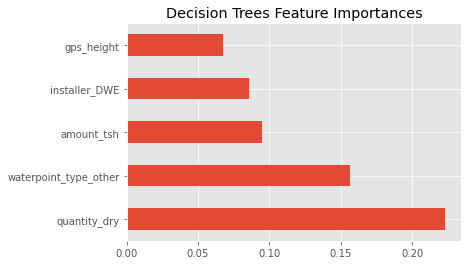

In [148]:
pd.Series(dt_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='Decision Trees Feature Importances'); 

## Bagged trees (from 30.04)

This model will train on different subsamples of the training data. We'll set the max depth to 8 and start with 20 estimators.

In [141]:
# instantiate a BaggingClassifier
bt_clf = BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', max_depth=8), n_estimators=20, random_state=SEED)
# fit to the training data
bt_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = bt_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.746
accuracy:  0.779


Here we've improved accuracy at the expense of recall. We do not consider this an improvement on the previous model (yet). Let's perform a similar analysis to what we did with tree depth earlier to see what the optimal number of estimators might be.

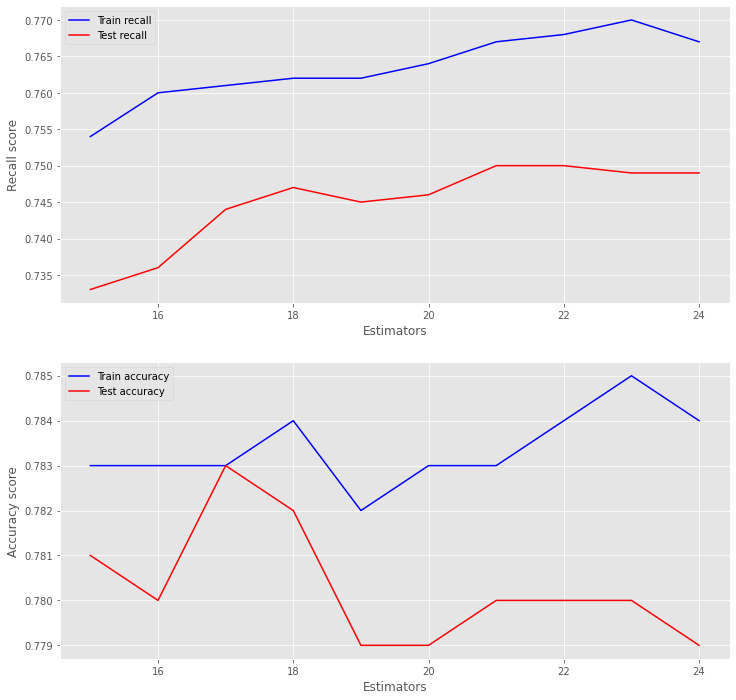

In [140]:
# identify the optimal tree depth for given data
estimator_list = list(range(15,25,1))
# create empty list for train results
train_recall_results, train_accuracy_results = [], []
# create empty list for test results
test_recall_results, test_accuracy_results = [], []
# iterate over max depths
for estimator in estimator_list:
    # instantiate a BaggingClassifier
    bt_clf = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=8), n_estimators=estimator, random_state=SEED)
    # fit to the training data
    bt_clf.fit(X_train, y_train)
    # find what the model predicts for the training data
    y_train_pred = bt_clf.predict(X_train)
    # calculate relevant statistics for training data
    train_recall, train_accuracy = summary(y_train, y_train_pred)
    # add data to list of train results
    train_recall_results.append(train_recall)
    train_accuracy_results.append(train_accuracy)
    # find what the model predicts for the test data
    y_test_pred = bt_clf.predict(X_test)
    # calculate relevant statistics for test data
    test_recall, test_accuracy = summary(y_test, y_test_pred)
    # add data to list of test results
    test_recall_results.append(test_recall)
    test_accuracy_results.append(test_accuracy)
    
# set up the plots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,12))

# specify the recall plot
ax1.plot(estimator_list, train_recall_results, 'b', label='Train recall')
ax1.plot(estimator_list, test_recall_results, 'r', label='Test recall')
ax1.set(xlabel='Estimators', ylabel='Recall score')
ax1.legend()

# specify the accuracy plot
ax2.plot(estimator_list, train_accuracy_results, 'b', label='Train accuracy')
ax2.plot(estimator_list, test_accuracy_results, 'r', label='Test accuracy')
ax2.set(xlabel='Estimators', ylabel='Accuracy score')
ax2.legend()

plt.show()

This suggests a nudge from 20 estimators to 22. We'll try that.

In [142]:
# instantiate a BaggingClassifier
bt_clf = BaggingClassifier(
    DecisionTreeClassifier(criterion='entropy', max_depth=8), n_estimators=22, random_state=SEED)
# fit to the training data
bt_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = bt_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.75
accuracy:  0.78


This improved the bagged trees model, but in our view it still falls short of the earlier decision tree model because the earlier decision tree model had a better recall score.

## Random Forest (from 30.04)

We'll use those same values for a random forest model.

In [143]:
# instantiate a RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=22, max_depth=8, random_state=SEED)
# fit to the training data
rf_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = rf_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.658
accuracy:  0.755


These results are worse and should be discarded. It could still be instructive to explore the feature importances.

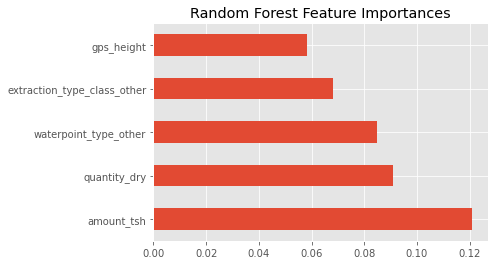

In [145]:
pd.Series(rf_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(
    kind='barh',title='Random Forest Feature Importances'); 

## GridSearchCV (from 30.05)

This will in theory take the best of all worlds from a decision tree classifier.

In [128]:
# set parameters for grid search
dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 6, 7, 8, 9, 10],
    "min_samples_split": [2, 3, 5, 7, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
}
# instantiate a GridSearchCV
gscv = GridSearchCV(DecisionTreeClassifier(random_state=SEED), dt_param_grid, cv=3, return_train_score=True)
# fit to the training data
gscv.fit(X_train, y_train)
# make predictions for the test data
y_pred = gscv.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.739
accuracy:  0.781


## Adaboost (from 30.07)

In [103]:
# instantiate an AdaBoostClassifier
ad_clf = AdaBoostClassifier(random_state=SEED)
# fit to the training data
ad_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = ad_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.701
accuracy:  0.75


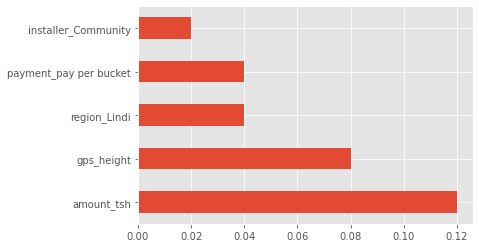

In [104]:
pd.Series(ad_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(kind='barh'); 

## Gradient Boost (from 30.07)

In [105]:
# instantiate an GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=SEED)
# fit to the training data
gb_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = gb_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.743
accuracy:  0.772


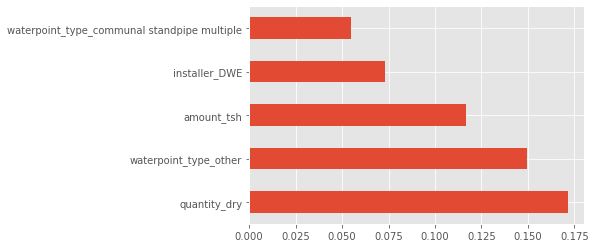

In [106]:
pd.Series(gb_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(kind='barh'); 

## XGBoost (from 30.09)

In [107]:
# instantiate an XGBClassifier
xg_clf = XGBClassifier()
# fit to the training data
xg_clf.fit(X_train, y_train)
# make predictions for the test data
y_pred = xg_clf.predict(X_test)
# show relevant statistics
print('recall:   ', summary(y_test,y_pred)[0])
print('accuracy: ', summary(y_test,y_pred)[1])

recall:    0.757
accuracy:  0.788


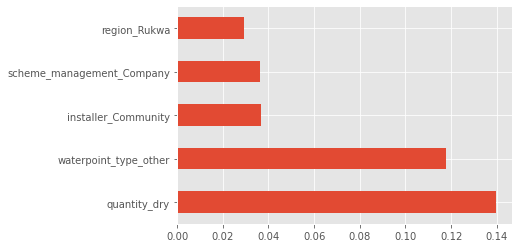

In [108]:
pd.Series(xg_clf.feature_importances_, index=X_train.columns).nlargest(5).plot(kind='barh'); 

# Evaluation

## Feature importances

In every model that provided us with feature importances except one, *quantity_dry* was identified as the first or second most important feature to the model. Let's look at just this feature.

In [155]:
df.quantity.value_counts()

enough          4681
insufficient    3022
dry              953
seasonal         306
unknown           91
Name: quantity, dtype: int64

In [154]:
compare_vals('quantity', ['dry', 'insufficient', 'seasonal', 'enough'])

dry 2%
insufficient 42%
seasonal 45%
enough 48%


About 10.5% of the wells had a "dry" quantity of water, and virtually all those wells are non-functional. The performance of these wells is clearly, distinctly worse than wells of all other water quantity designations, even "insufficient". All the others performed in the 42-48% range.

Another prominent feature was *waterpoint_type_other*, which refers to the type of water pump. Let's look more closely at it.

In [156]:
df.waterpoint_type.value_counts()

communal standpipe             5257
communal standpipe multiple    1399
hand pump                      1152
other                          1138
improved spring                  76
cattle trough                    30
dam                               1
Name: waterpoint_type, dtype: int64

In [158]:
compare_vals('waterpoint_type', ['other', 'communal standpipe multiple', 'communal standpipe', 'hand pump'])

other 10%
communal standpipe multiple 24%
communal standpipe 49%
hand pump 52%


Unfortunately we don't know exactly what this "other" distinction means, but it is evidently worth attention.

The last prominently important feature was *amount_tsh*, which refers to the vertical distance between the water surface level of the well and the greatest height the water reaches before it exits the pump. This was one of the few numerical features we used. As such, we can get a better look at its effect on well performance on a scatterplot.

In [174]:
df[df.amount_tsh > 10]['target'].value_counts()

0    1286
1     735
Name: target, dtype: int64

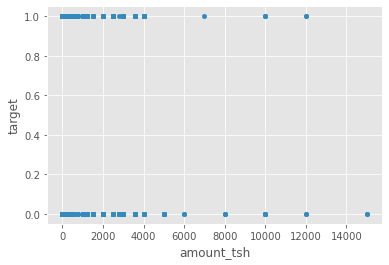

In [162]:
df[df.amount_tsh < 25000].plot.scatter(x='amount_tsh', y='target');

In [221]:
x_vals = [1, 20, 40, 100, 200, 400, 1000, 2500, 1000000]

for i in range(len(x_vals)):
    if x == 0:
        y[i] = 
    n = df[df.amount_tsh < x].value_counts().sum()
    print(x, n)

# specify the recall plot
# plot(estimator_list, train_recall_results, 'b', label='Train recall')
# plot(estimator_list, test_recall_results, 'r', label='Test recall')
# set(xlabel='Estimators', ylabel='Recall score')
# legend()

0 0
1 6991
2 6991
3 6991
4 6991
5 6991
6 6991
7 6991
8 6995


# Recommendations

Use this information to ...

* choose where to put wells in order to guarantee better performance
* know where to look for wells that require more frequent repair